# Regression Task

---






In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import pandas as pd

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' #force Environment variable to synchronous computation

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset, SubsetRandomSampler
from torchvision import transforms

In [ ]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

--2022-08-22 10:12:19--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv’

train_data.csv      100%[===================>]   3.69K  --.-KB/s    in 0s      

2022-08-22 10:12:19 (46.3 MB/s) - ‘regression_dataset/train_data.csv’ saved [3776/3776]

--2022-08-22 10:12:19--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regression_dataset/test_data.csv’

test_data.csv 

In [ ]:
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        # Read the file and split the lines in a list
        with open(csv_file, 'r') as f:
            lines = f.read().split('\n')
        # Get x and y values from each line and append to self.data
        self.data = []
        for line in lines[1:-1]:
            sample = line.split(',')
            self.data.append((float(sample[0]), float(sample[1])))
        # Now self.data contains all our dataset.
        # Each element of the list self.data is a tuple: (input, output)

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [ ]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

In [ ]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('regression_dataset/train_data.csv', transform=composed_transform)
test_dataset = CsvDataset('regression_dataset/test_data.csv', transform=composed_transform)

In [ ]:
# Define model
class ConvNet(nn.Module):
    def __init__(self):

        super().__init__()
        self.fc1 = nn.Linear(in_features=1, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=256)
        self.out = nn.Linear(in_features=256, out_features=1)
        self.act = nn.Sigmoid()
        
    def forward(self, x):
      
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)

        return x


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
criterion = nn.MSELoss()

dataset = ConcatDataset([train_dataset, test_dataset])

num_epochs=3000
batch_size=32
k=5
splits=KFold(n_splits=k,shuffle=True,random_state=42)

In [ ]:
foldperf={}

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

  print('Fold {}'.format(fold + 1))

  train_sampler = SubsetRandomSampler(train_idx)
  test_sampler = SubsetRandomSampler(val_idx)
  train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
  test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
  
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  
  model = ConvNet()
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.002)

  history = {'train_loss': [], 'test_loss': []}

  for epoch in range(num_epochs):

    model.train()
    for data, labels in train_loader:
      data,labels = data.to(device),labels.to(device)
      output = model(data)
      loss = criterion(output,labels)
      model.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss = loss.detach().cpu().numpy()

    model.eval()
    for data, labels in test_loader:
      data,labels = data.to(device),labels.to(device)
      output = model(data)
      loss=criterion(output,labels)
      test_loss = loss.detach().cpu().numpy()

    print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f}".format(epoch + 1, num_epochs, train_loss, test_loss))

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    
  foldperf['fold{}'.format(fold+1)] = history

Streaming output truncated to the last 5000 lines.
Epoch:1002/3000 AVG Training Loss:0.192 AVG Test Loss:0.175
Epoch:1003/3000 AVG Training Loss:0.109 AVG Test Loss:0.440
Epoch:1004/3000 AVG Training Loss:0.186 AVG Test Loss:0.230
Epoch:1005/3000 AVG Training Loss:0.167 AVG Test Loss:0.081
Epoch:1006/3000 AVG Training Loss:0.174 AVG Test Loss:0.185
Epoch:1007/3000 AVG Training Loss:0.115 AVG Test Loss:0.186
Epoch:1008/3000 AVG Training Loss:0.142 AVG Test Loss:0.162
Epoch:1009/3000 AVG Training Loss:0.143 AVG Test Loss:0.313
Epoch:1010/3000 AVG Training Loss:0.116 AVG Test Loss:0.260
Epoch:1011/3000 AVG Training Loss:0.241 AVG Test Loss:0.271
Epoch:1012/3000 AVG Training Loss:0.145 AVG Test Loss:0.287
Epoch:1013/3000 AVG Training Loss:0.169 AVG Test Loss:0.208
Epoch:1014/3000 AVG Training Loss:0.257 AVG Test Loss:0.155
Epoch:1015/3000 AVG Training Loss:0.163 AVG Test Loss:0.278
Epoch:1016/3000 AVG Training Loss:0.148 AVG Test Loss:0.405
Epoch:1017/3000 AVG Training Loss:0.237 AVG Test 

In [ ]:
train_loss_log = []
val_loss_log = []

for i in range(num_epochs):
  
  train_loss_log.append((foldperf['fold1']['train_loss'][i] +
                          foldperf['fold2']['train_loss'][i] +
                          foldperf['fold3']['train_loss'][i] +
                          foldperf['fold4']['train_loss'][i] +
                          foldperf['fold5']['train_loss'][i]
                          ) / 5)
  
  val_loss_log.append((foldperf['fold1']['test_loss'][i] +
                          foldperf['fold2']['test_loss'][i] +
                          foldperf['fold3']['test_loss'][i] +
                          foldperf['fold4']['test_loss'][i] +
                          foldperf['fold5']['test_loss'][i]
                          ) / 5)

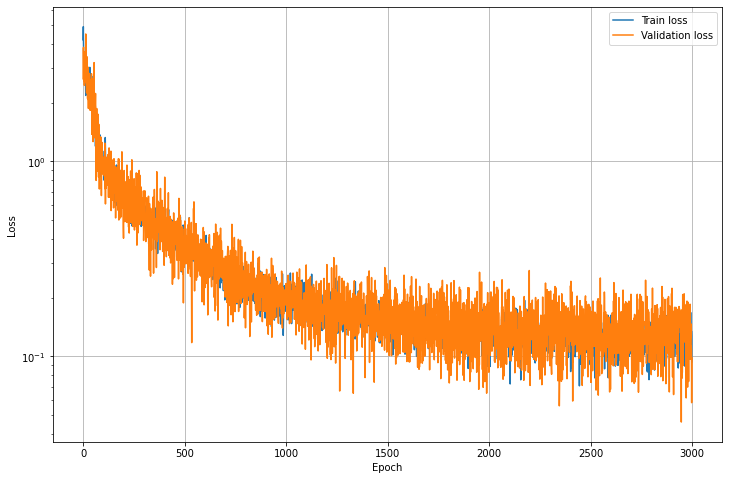

In [ ]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

Input shape: torch.Size([1000, 1])


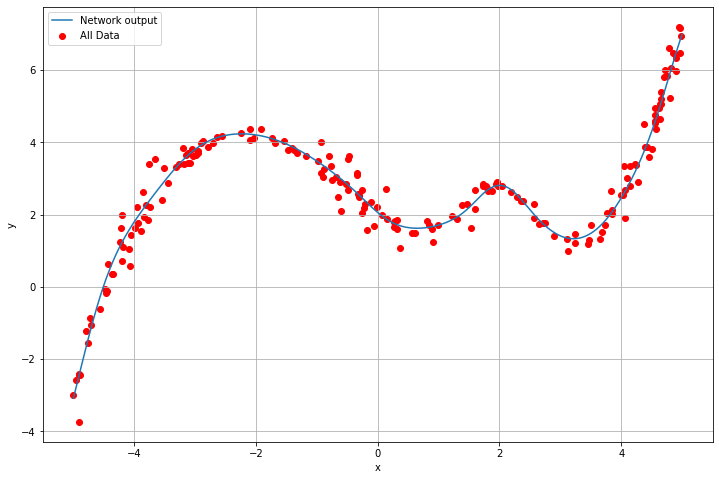

In [ ]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')
all_data_df = pd.concat([train_df, test_df], axis=0)

# Input vector
x_vec = torch.linspace(-5,5,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")

# Network output
model.eval()
with torch.no_grad(): # turn off gradients computation
    y_vec = model(x_vec)

# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

# Plot output
plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output')
plt.scatter(all_data_df.input, all_data_df.label, label='All Data', color='red')
#plt.plot(x_vec, true_model, label='True model')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()